<font size=7>**Temperature anomalies**</font>

# Context

Temperature metering is cheap and easy, so it is largely deployed. Though beside using this information for controlling specific devices, it can be combined with other sensors and used to indicate system malfunction or deficiencies.

# Imports
Imports useful tools and tables for the demonstration. To use the code, make sure you can import all required libraries, including the Onboard Data API `onboard.client`. An API key is required, the current code reads it from a file named `api_key` in the same directory as current notebook (not included).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def _get_client(path):
    """Returns the client for key in indicated file"""
    return RtemClient(api_key=_get_key(path))

def _get_key(path):
    """Returns the key from indicated file"""
    with open(path, 'r') as keyfile:
        key = keyfile.readline().replace("\n",'')
    return key

from onboard.client import RtemClient
from onboard.client.models import PointSelector, TimeseriesQuery
from onboard.client.dataframes import points_df_from_streaming_timeseries
client = _get_client('./api_key')

In [2]:
def _get_equip_query(equip, point_types=['Zone Temperature','Return Air Temperature'], start='2018',end='2021', i=0, n_tot=None):
    """Function to query specific point types from one equipment
    Parameter:
    ----------
        equip: int
            equipment id
        point_types: list-like, optional
            list of point types. Default ['Zone Temperature','Return Air Temperature']
        start: str, optional
            start date of the query
        end: str, optional
            end date of the query
        i: integer, optional
            counter for display
        n_tot: integer, optional
            total number of cases, for display. Default None (i.e. no display)
    
    Return:
    -------
        pandas DataFrame with point data and the point ids as column names
    """
    query = PointSelector()
    query.equipment = [equip]
    query.point_types = point_types
    selection = client.select_points(query)

    ## Select the time period
    start,end = pd.to_datetime([start,end]).view(int)/1e6

    ### Report what we are downloading
    if n_tot is not None: print(f"{i+1}/{n_tot}... ", end='\r')
    
    if len(selection['points'])==0: return pd.DataFrame()
    else:
        ts_query = TimeseriesQuery(point_ids=selection['points'],start=start,end=end)
        sensor_data = points_df_from_streaming_timeseries( client.stream_point_timeseries(ts_query) )
        if sensor_data.shape[0]>0:
            sensor_data.set_index('timestamp', inplace=True)
            sensor_data.index = pd.to_datetime(sensor_data.index)
        return sensor_data

In [3]:
### Query is heavy, a csv version is used instead
if os.path.isfile("./all_info.csv"):
    all_points = pd.read_csv("./all_info.csv", index_col=0)
else:
    all_points = pd.json_normalize( client.get_all_points() ).set_index('id')
    all_points.to_csv("./all_info.csv",index=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
### Query is heavy, a csv version is used instead
if os.path.isfile("./all_equipments.csv"):
    all_equip = pd.read_csv("./all_equipments.csv", index_col=0)
else:
    all_equip = pd.json_normalize( client.get_all_equipment() ).set_index('id')
    all_equip.to_csv("./all_equipments.csv",index=True)

# Combining zone temperature with cooling output

Some buildings have sensors to tell how much a device is used (in %). This information allows to know that the device is used, and also directly if it is struggling to maintain temperature in a room. This can be observed with cooling devices in the summer.

In [5]:
fields = ['Zone Temperature','Zone Temperature Setpoint','Heating Output','Cooling Output']
equip = 21754

time_series = _get_equip_query(equip=equip, point_types=fields) # Query the time series
time_series.rename(columns=all_points.loc[time_series.columns,'type'].to_dict(), inplace=True) # Rename columns

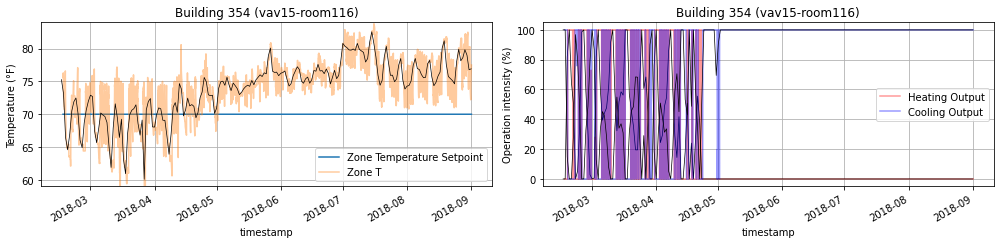

In [6]:
fig,axes = plt.subplots(1,2,figsize=(14,3.5))

#### Zone Temperature
time_series.loc[:,'Zone Temperature Setpoint'].plot(ax=axes[0], legend=True)
time_series.loc[:,'Zone Temperature'].plot(ax=axes[0], alpha=.4, label='Zone T', legend=True)
time_series.loc[:,'Zone Temperature'].resample('d').mean().plot(ax=axes[0], linewidth=.7, color='k', legend=False)
axes[0].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[0].grid()
axes[0].set_ylabel("Temperature (°F)")
axes[0].set_ylim([59,84])

#### Heating and Cooling outputs
### Heating
time_series.loc[:,'Heating Output'].plot(ax=axes[1], alpha=.4, color='r', legend=True)
time_series.loc[:,'Heating Output'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
### Cooling
time_series.loc[:,'Cooling Output'].plot(ax=axes[1], alpha=.4, color='b', legend=True)
time_series.loc[:,'Cooling Output'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
### Add-ons
axes[1].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[1].grid()
axes[1].set_ylabel("Operation intensity (%)")

plt.tight_layout()
plt.savefig('./images/withCoolingOutput.png',bbox_inches='tight')

From Feb. to May, the VAV device alternatively uses heating and cooling to stabilize the room temperature. Starting in May, the zone temperature raises above the setpoint. Heating device is turned off while cooling is maxed out without being able to lower the room temperature.

Similar examples can be found for the same building 354:
+ equipment vav15-room50 (id: 21790)
+ equipment vav-nurseOffice (id: 21742, period: May-July 2018)

# Combining zone temperature with heating output

Similar effect can be observed with heating devices.

In [7]:
fields = ['Zone Temperature','Zone Temperature Setpoint','Heating Output','Cooling Output']
equip = 21760
span = ['2018-03','2018-04-10']

time_series = _get_equip_query(equip=equip, point_types=fields, start=span[0], end=span[1]) # Query the time series
time_series.rename(columns=all_points.loc[time_series.columns,'type'].to_dict(), inplace=True) # Rename columns

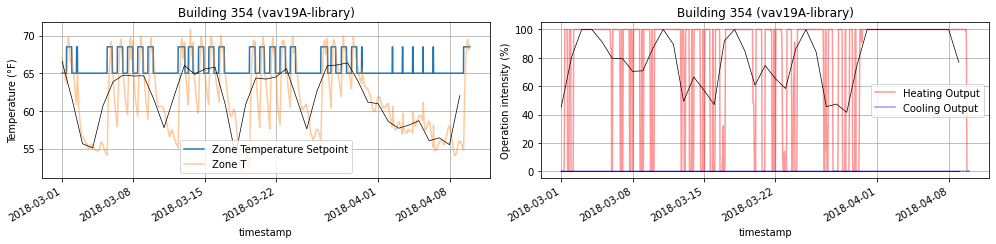

In [8]:
fig,axes = plt.subplots(1,2,figsize=(14,3.5))

#### Zone Temperature
time_series.loc[:,'Zone Temperature Setpoint'].plot(ax=axes[0], legend=True)
time_series.loc[:,'Zone Temperature'].plot(ax=axes[0], alpha=.4, label='Zone T', legend=True)
time_series.loc[:,'Zone Temperature'].resample('d').mean().plot(ax=axes[0], linewidth=.7, color='k', legend=False)
axes[0].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[0].grid()
axes[0].set_ylabel("Temperature (°F)")

#### Heating and Cooling outputs
### Heating
time_series.loc[:,'Heating Output'].plot(ax=axes[1], alpha=.4, color='r', legend=True)
time_series.loc[:,'Heating Output'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
### Cooling
time_series.loc[:,'Cooling Output'].plot(ax=axes[1], alpha=.4, color='b', legend=True)
time_series.loc[:,'Cooling Output'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
### Add-ons
axes[1].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[1].grid()
axes[1].set_ylabel("Operation intensity (%)")

plt.tight_layout()
plt.savefig('./images/withHeatingOutput.png',bbox_inches='tight')

Overall trend shows zone temperatures barely/rarely reaching the setpoint (left) while heating device is extensively used (right). This is particularly highlighted between March 2 and march 5, and March 29 to April 10, where heating device is used at its maximum while the zone temperature drops down to 10F below the 65F setpoint.

A similar example can be found for the same building 354:
+ equipment vav-libraryConf (id: 21740, period: same)

# Combining zone temperature with fan speed and damper position

Fan speed allows to know if the VAV or AHU is active, while valve position enables adjustment.

In [9]:
fields = ['Zone Temperature','Zone Temperature Setpoint','Damper Position','Speed']
equip = 20371
span = ['2019-01-14 12:00','2019-01-16 12:00']

time_series = _get_equip_query(equip=equip, point_types=fields, start=span[0], end=span[1]) # Query the time series
time_series.rename(columns=all_points.loc[time_series.columns,'type'].to_dict(), inplace=True) # Rename columns

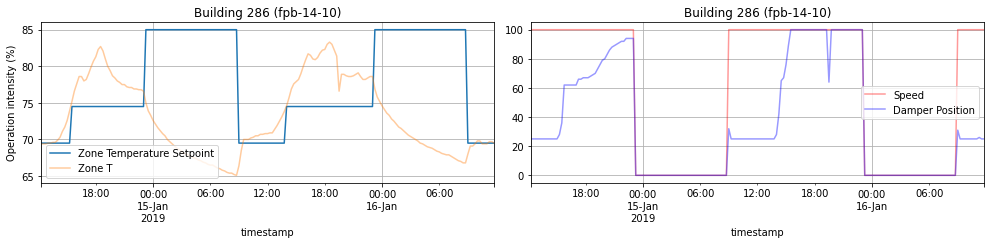

In [10]:
fig,axes = plt.subplots(1,2,figsize=(14,3.5))

#### Zone Temperature
time_series.loc[:,'Zone Temperature Setpoint'].plot(ax=axes[0], legend=True)
time_series.loc[:,'Zone Temperature'].plot(ax=axes[0], alpha=.4, label='Zone T', legend=True)
#time_series.loc[:,'Zone Temperature'].resample('d').mean().plot(ax=axes[0], linewidth=.7, color='k', legend=False)
axes[0].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[0].grid()
axes[0].set_ylabel("Temperature (°F)")

#### Heating and Cooling outputs
### Heating
time_series.loc[:,'Speed'].plot(ax=axes[1], alpha=.4, color='r', legend=True)
#time_series.loc[:,'Speed'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
### Cooling
time_series.loc[:,'Damper Position'].plot(ax=axes[1], alpha=.4, color='b', legend=True)
#time_series.loc[:,'Damper Position'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
### Add-ons
axes[1].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[1].grid()
axes[0].set_ylabel("Operation intensity (%)")

plt.tight_layout()
plt.savefig('./images/withSpeedAndDamper.png',bbox_inches='tight')

From 5pm to 11pm, the building is heated (with speed and damper position at 100%, i.e. working max capacity), raising the zone temperature to 8F above the setpoint at 6pm.

The observed 2 days of operation may result from the algorithm aiming at overheating the building to limit the effort at heating again the next morning.

This example also highlights the loss of zone temperature during the night, allowing further thermal explorations of the zone properties.

A similar example can be found for the same building 286, with high damper position and speed along with temperature largely above the setpoint (cooling limitation):
+ equipment fpb-11-7 (id: 20370, period: Jul-Aug 2019)

# Combining zone temperature with mixed air temperature

In [11]:
fields = ['Zone Temperature','Zone Temperature Setpoint','Supply Air Temperature','Supply Air Temperature Setpoint','Mixed Air Temperature','Mixed Air Temperature Setpoint']
equip = 34966
span = ['2019-07','2019-07-13']

time_series = _get_equip_query(equip=equip, point_types=fields, start=span[0], end=span[1]) # Query the time series
time_series.rename(columns=all_points.loc[time_series.columns,'type'].to_dict(), inplace=True) # Rename columns

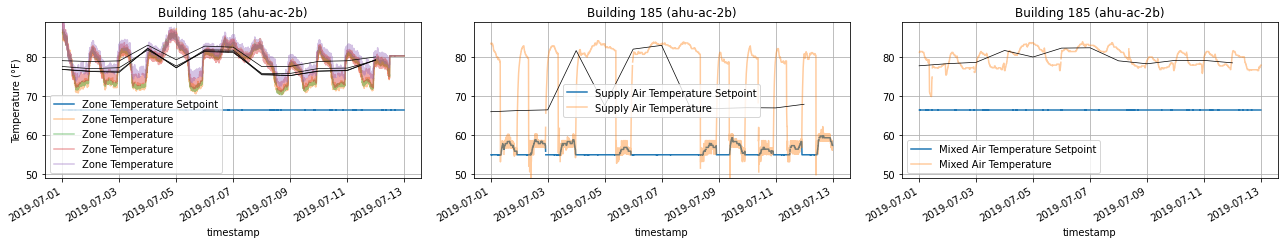

In [12]:
fig,axes = plt.subplots(1,3,figsize=(18,3.5))

#### Zone Temperature
time_series.loc[:,'Zone Temperature Setpoint'].plot(ax=axes[0], legend=True)
time_series.loc[:,'Zone Temperature'].plot(ax=axes[0], alpha=.4, label='Zone T', legend=True)
time_series.loc[:,'Zone Temperature'].resample('d').mean().plot(ax=axes[0], linewidth=.7, color='k', legend=False)
axes[0].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[0].grid()
axes[0].set_ylabel("Temperature (°F)")
axes[0].set_ylim([49,89])

#### Supply Temperature
time_series.loc[:,'Supply Air Temperature Setpoint'].plot(ax=axes[1], legend=True)
time_series.loc[:,'Supply Air Temperature'].plot(ax=axes[1], alpha=.4, legend=True)
time_series.loc[:,'Supply Air Temperature'].resample('d').mean().plot(ax=axes[1], linewidth=.7, color='k', legend=False)
axes[1].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[1].grid()
axes[0].set_ylabel("Temperature (°F)")
axes[1].set_ylim([49,89])

#### Mixed Temperature
time_series.loc[:,'Mixed Air Temperature Setpoint'].plot(ax=axes[2], legend=True)
time_series.loc[:,'Mixed Air Temperature'].plot(ax=axes[2], alpha=.4, legend=True)
time_series.loc[:,'Mixed Air Temperature'].resample('d').mean().plot(ax=axes[2], linewidth=.7, color='k', legend=False)
axes[2].set_title(f"Building {all_equip.loc[equip,'building_id']} ({all_equip.loc[equip,'equip_id']})")
axes[2].grid()
axes[0].set_ylabel("Temperature (°F)")
axes[2].set_ylim([49,89])

plt.tight_layout()
plt.savefig('./images/withSupplyT.png',bbox_inches='tight')

The zone temperature observed is on average 10-15 F above the setpoint. The setting and temperature on the supply side indicate a cooling device is operating, with the supply air temperature matching its setpoint closely in operating periods. Though the mixed air (introduced in the room) also shows an average temperature of 15F above the setpoint. The zone temperature can not be adjusted to the setpoint, even in moments when the cooling device clearly operates. These observations indicate the AHU can not ensure the cooling demand required in the room.